In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [ ]:
!pip install patool
import patoolib


In [ ]:
patoolib.extract_archive("drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar", outdir="drive/MyDrive/dataset/imageCaption")

INFO patool: Extracting drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar ...
INFO:patool:Extracting drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar ...
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar
INFO patool:     with cwd='drive/MyDrive/dataset/imageCaption', input=''
INFO:patool:    with cwd='drive/MyDrive/dataset/imageCaption', input=''


PatoolError: Command `['/usr/bin/unrar', 'x', '--', '/content/drive/MyDrive/dataset/imageCaption/Flicker8kDataset.rar']' returned non-zero exit status 255

In [ ]:
data = pd.read_csv("drive/MyDrive/dataset/imageCaption/Flickr8k.lemma.token.txt", header=None, delimiter="	", names=["id", "caption"])
data['id'] = data['id'].str.split('.').str[0]
data['id'] = data['id'].apply(lambda x: x + ".jpg")
data

ParserError: Error tokenizing data. C error: Expected 2 fields in line 13398, saw 3


In [ ]:
image_path="drive/MyDrive/dataset/imageCaption/Flicker8k_Dataset"

In [ ]:
data = data[data['id'] != "2258277193_586949ec62.jpg"]
data = data.reset_index(drop=True)
data

id  \
0      1305564994_00513f9a5b.jpg   
1      1305564994_00513f9a5b.jpg   
2      1305564994_00513f9a5b.jpg   
3      1305564994_00513f9a5b.jpg   
4      1305564994_00513f9a5b.jpg   
...                          ...   
13393  3273625566_2454f1556b.jpg   
13394  3273625566_2454f1556b.jpg   
13395   327415627_6313d32a64.jpg   
13396   327415627_6313d32a64.jpg   
13397   327415627_6313d32a64.jpg   

                                                 caption  
0      A man in street racer armor be examine the tir...  
1             Two racer drive a white bike down a road .  
2      Two motorist be ride along on their vehicle th...  
3      Two person be in a small race car drive by a g...  
4           Two person in race uniform in a street car .  
...                                                  ...  
13393                     A greyhound be run in a race .  
13394  A race dog have a muzzle and be wear striped j...  
13395  Two dog run along the green grass near the wat...  
13396                          Two dog run past a tree .  
13397                                                Two  

[13398 rows x 2 columns]

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"drive/MyDrive/dataset/imageCaption/Flicker8k_Dataset/{temp_df.id[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

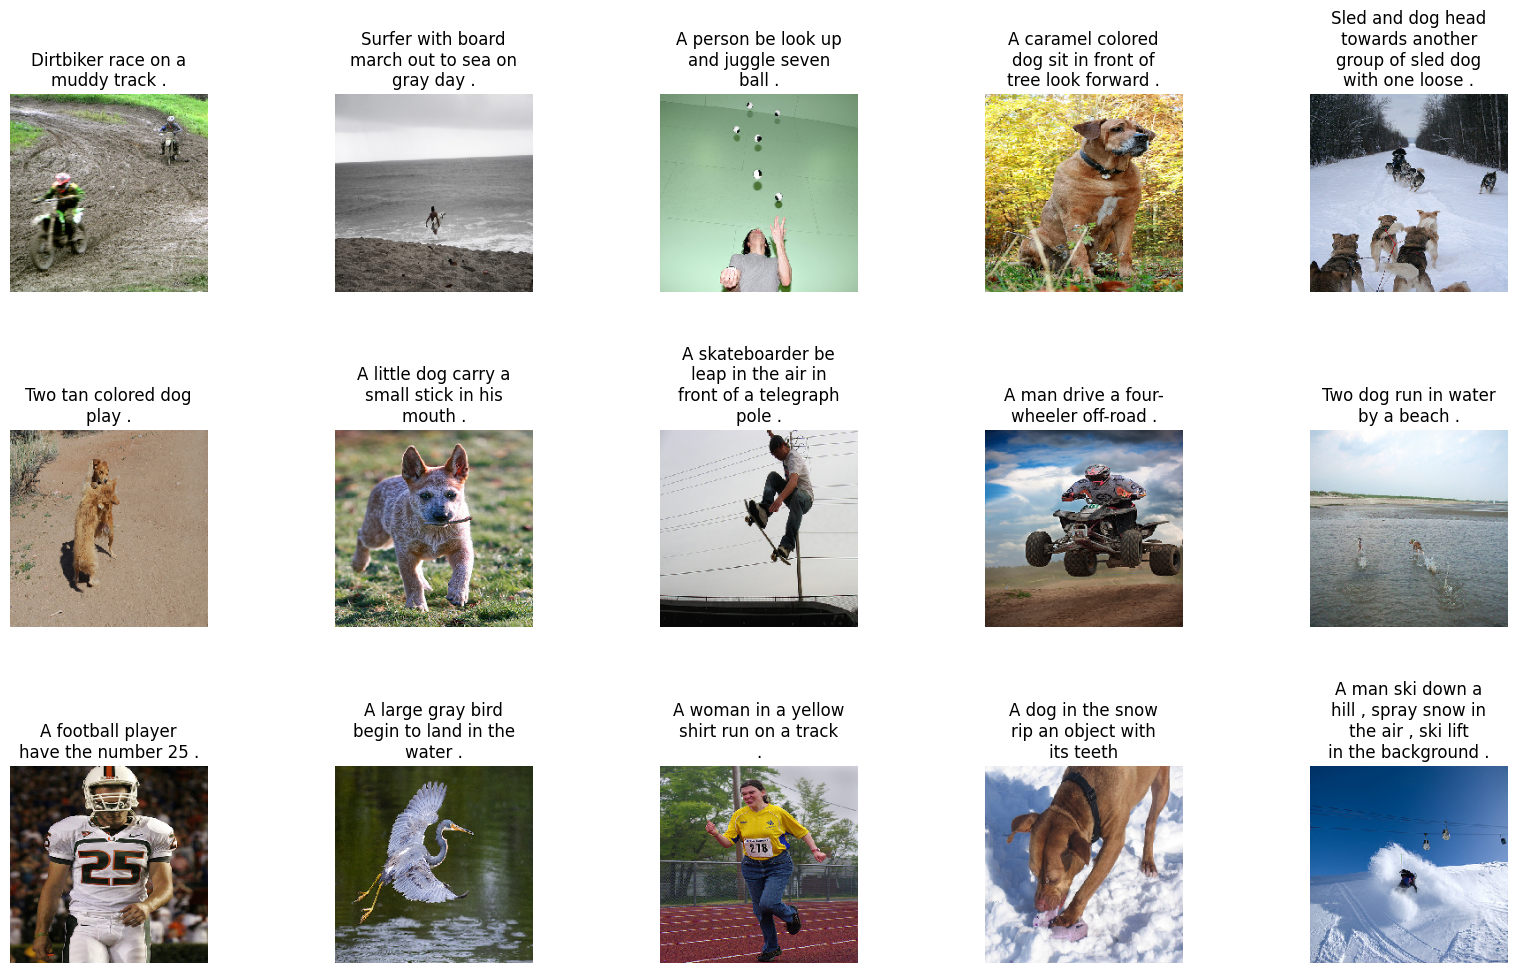

In [ ]:
display_images(data.sample(15))

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

["startseq man in street racer armor be examine the tire of another racer 's motorbike endseq",
 'startseq two racer drive white bike down road endseq',
 'startseq two motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq two person be in small race car drive by green hill endseq',
 'startseq two person in race uniform in street car endseq',
 'startseq firefighter extinguish fire under the hood of car endseq',
 'startseq fireman spray water into the hood of small white car on jack endseq',
 'startseq fireman spray inside the open hood of small white car on jack endseq',
 'startseq fireman use firehose on car engine that be up on carjack endseq',
 'startseq firefighter use water to extinguish car that be on fire endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['id'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['id'].isin(train_images)]
test = data[data['id'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[20]])

[[1, 9, 5, 161, 29, 594, 7, 140, 106, 2]]

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
print(fe.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
# extract features from image
features = {}
directory = image_path

for image in tqdm(os.listdir(directory)):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [34:09<00:00,  3.95it/s]


In [ ]:
#Data Generation
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
#Modelling
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [ ]:
from tensorflow.keras.utils import plot_model

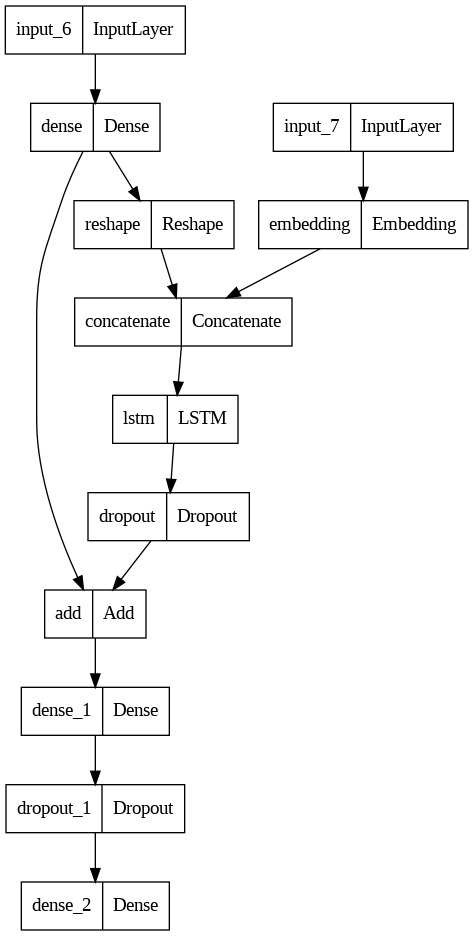

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_6[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='id',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='id',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 4.8814
Epoch 1: val_loss improved from inf to 4.30537, saving model to model.h5
537/537 [==============================] - 3181s 6s/step - loss: 4.8814 - val_loss: 4.3054 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


537/537 [==============================] - ETA: 0s - loss: 3.9969
Epoch 2: val_loss improved from 4.30537 to 3.98029, saving model to model.h5
537/537 [==============================] - 668s 1s/step - loss: 3.9969 - val_loss: 3.9803 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.7559
Epoch 3: val_loss improved from 3.98029 to 3.84403, saving model to model.h5
537/537 [==============================] - 665s 1s/step - loss: 3.7559 - val_loss: 3.8440 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.6091
Epoch 4: val_loss improved from 3.84403 to 3.76755, saving model to model.h5
537/537 [==============================] - 667s 1s/step - loss: 3.6091 - val_loss: 3.7676 - lr: 0.0010
Epoch 5/50
537/537 [==============================] - ETA: 0s - loss: 3.5039
Epoch 5: val_loss improved from 3.76755 to 3.72302, saving model to model.h5
537/537 [==============================] - 666s 1s/step - loss: 3.5039 - val_loss: 3.7

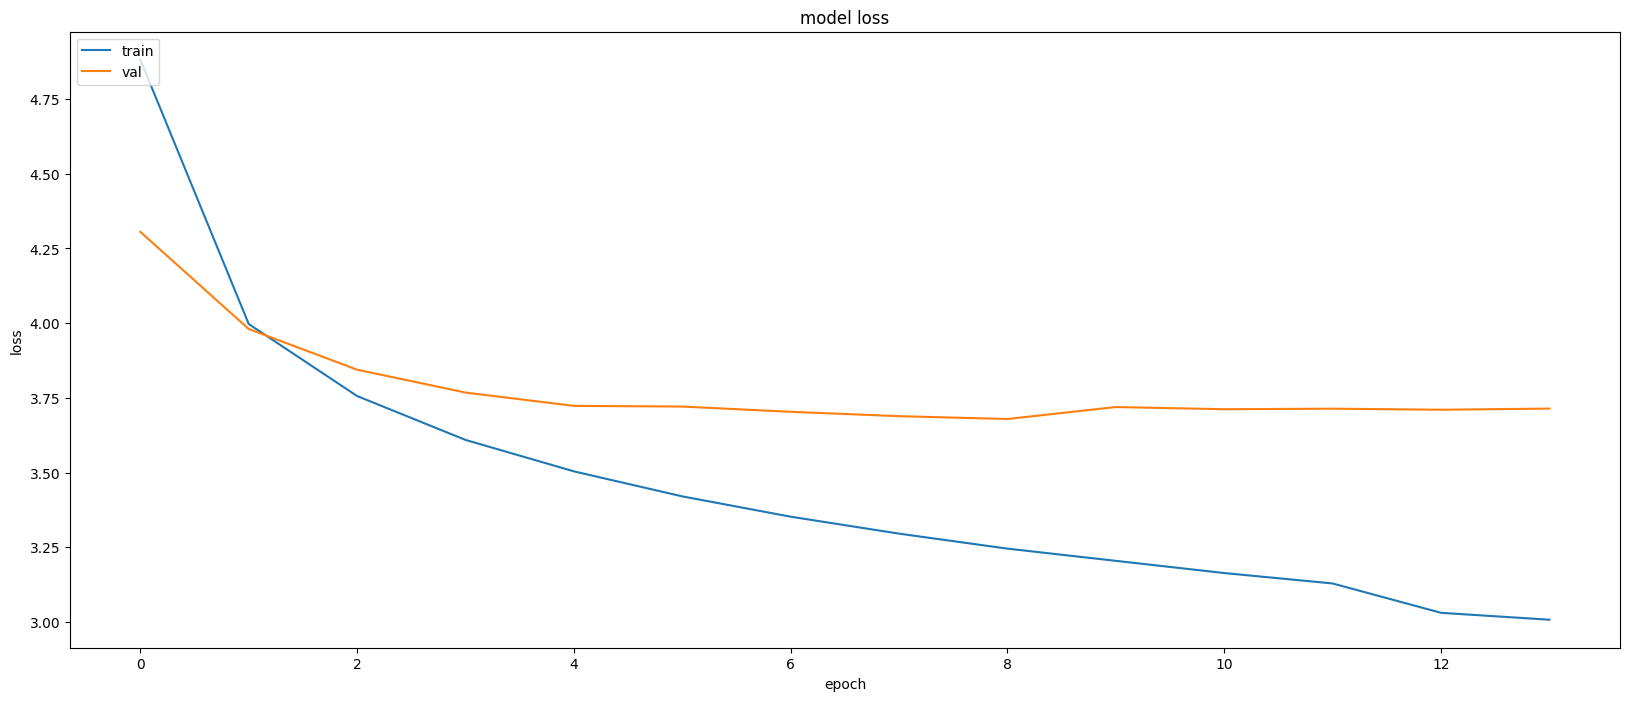

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['id']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['id'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 24ms/step


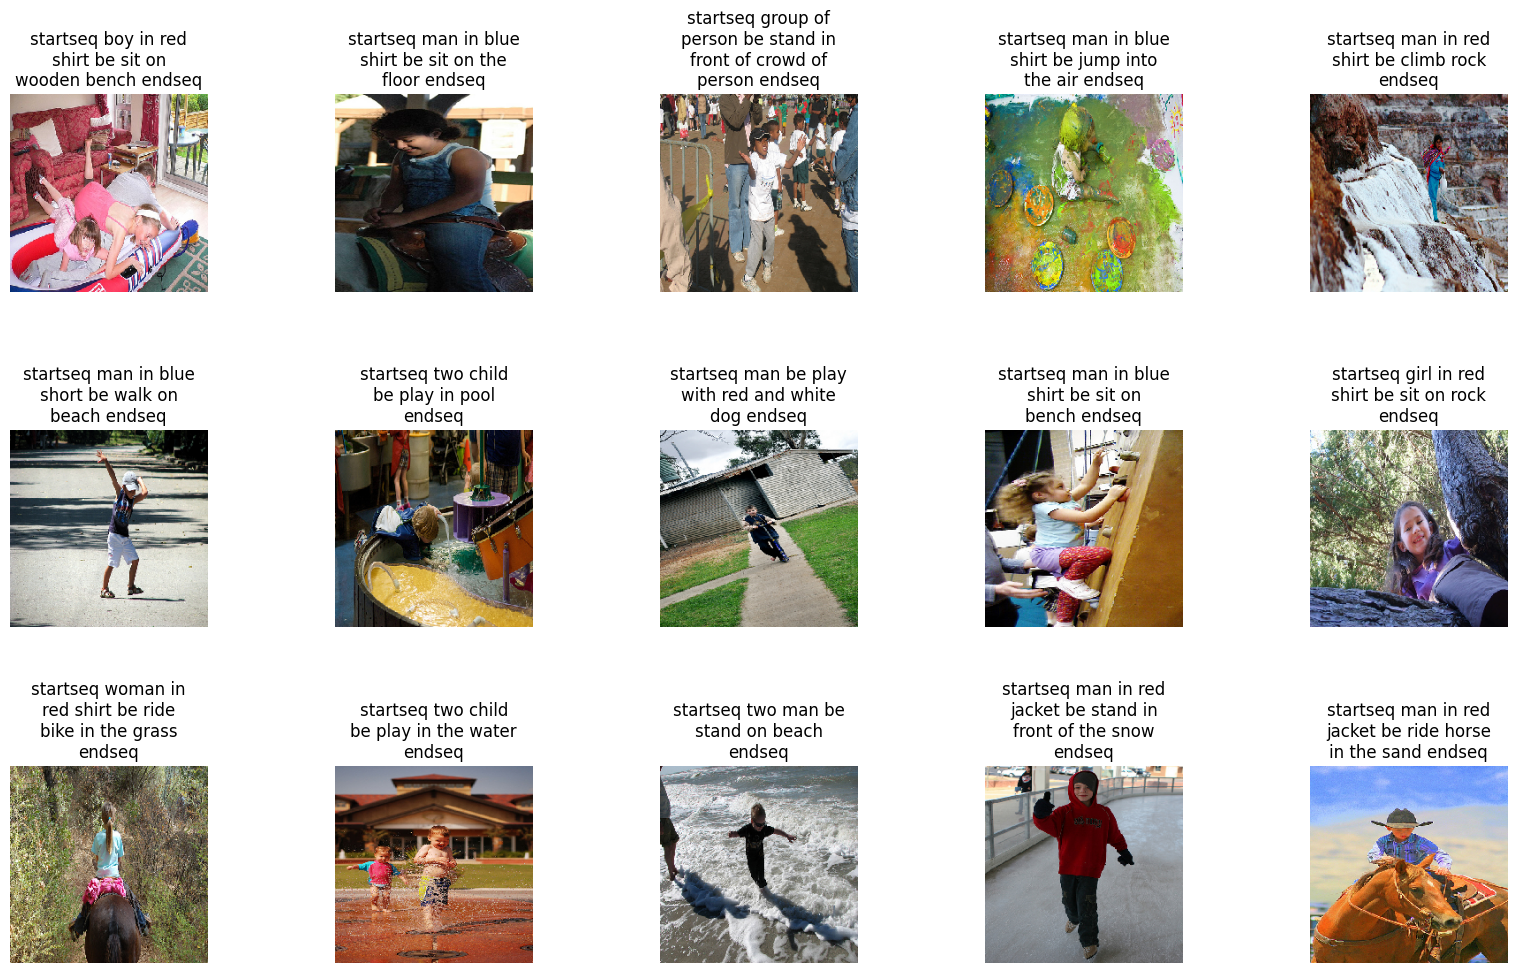

In [ ]:
display_images(samples)